In [1]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from brainbox import physiology as phys

# 1. Estimating model receptive fields

This sections outlines how you can estimate the spatio-temporal receptive fields (RFs) of your model. In order to estimate the RFs, brainbox adopts a technique used by neurophysiologists known as spike-triggered average (STA). Here the models units activations are recorded in response to a sequence of white-noise stimuli, from which the RFs are approximated by weighting the input stimuli by the respective activations they elicit. This works for both continuous output (*i.e.* rate coded models) as well as binary outputs (*i.e.* spiking models).

To portray how this works, we load some example RFs from a rate-coded model which was trained to predict the immediate future from a sequence of past video frames (Singer et al., 2018). As we already have the RFs of this model we do not acctually need to estimate them, however it gives us a good control for checking that the RFs that we will estimate using STA acctually produce the correct results. You will only need to estimate the RFs of your model if you cannot directly linearise the units within your model (e.g. you want to find the RF of a downstream unit within a hierarchincal model with non-linear activations or you want to find the RF of unit within a single-hidden layer model that employs recurrent connections).

In [3]:
model_rfs = torch.load('misc/rate_weights.pt').detach().cpu()

In order to estimate the RFs within your model, you will need to modify the function below that acts as a wrapper for passing input (*i.e.* the white-noise stimuli) to your model for which you will need to return the activations of the units you wish to obtain the RFs for. The noise input is supplied as a tensor with shape $b \times t\_len \times rf\_h \times rf\_w$ referring to the batch size, stimuli duration, stimuli spatial height and stimuli spatial width respectively. The wrapper function will need to return a tensor of shape $batch \times n\_units \times t\_len$ which refers to the batch, number of model units and time duration respectively (note: the time duration of the model output does not need to be equal to the duration of the white noise stimuli).

In [77]:
def model_output(noise):
    # noise: batch x t_len x rf_h x rf_w
    # return: batch x n_units x t_len
    model_outputs = []
    
    # You would replace the code below for your model
    rf_len = model_rfs.shape[1]
    for t in range(rf_len-1, noise.shape[1]):
        model_outputs.append(torch.einsum('bthw, nthw->bn', noise[:, t-rf_len+1:t+1], model_rfs.cuda()))
    
    return torch.stack(model_outputs, dim=2)

In [5]:
estimated_model_rfs = phys.estimate_rfs(model_output, rf_len=5, rf_h=20, rf_w=20, t_len=20, noise_var=4, samples=20000, batch_size=1000, device='cuda')

Processing batch_id 0 out of 20...
Processing batch_id 1 out of 20...
Processing batch_id 2 out of 20...
Processing batch_id 3 out of 20...
Processing batch_id 4 out of 20...
Processing batch_id 5 out of 20...
Processing batch_id 6 out of 20...
Processing batch_id 7 out of 20...
Processing batch_id 8 out of 20...
Processing batch_id 9 out of 20...
Processing batch_id 10 out of 20...
Processing batch_id 11 out of 20...
Processing batch_id 12 out of 20...
Processing batch_id 13 out of 20...
Processing batch_id 14 out of 20...
Processing batch_id 15 out of 20...
Processing batch_id 16 out of 20...
Processing batch_id 17 out of 20...
Processing batch_id 18 out of 20...
Processing batch_id 19 out of 20...


The *estimate_rfs* function above takes a variety of arguments to customise the RF fitting process, where the most import are the *rf_len* which define the temporal length of your RFs; the *rf_h* and *rf_w* defning the spatial height and width of the RFs; and *t_len*, *noise_var*, *samples* which define the stimulus duration, variance of the sampled gaussian noise and the number of stimulus sequences respectively (the more stimulus sequences are shown the better the RF estimation will be).


We inspect the estimated RFs (bottom row) and observe that they align with the real RFs of the model (top row)!

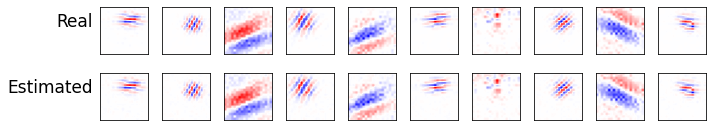

In [9]:
n = 10
fig, axs = plt.subplots(2, n, figsize=(10, 2))

for i in range(n):
    real_v = model_rfs[i, -1].abs().max()
    est_v = estimated_model_rfs[i, -1].abs().max()
    axs[0, i].imshow(model_rfs[i, -1], vmin=-real_v, vmax=real_v, cmap='bwr')
    axs[1, i].imshow(estimated_model_rfs[i, -1], vmin=-est_v, vmax=est_v, cmap='bwr')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
axs[0, 0].set_ylabel('Real', rotation=0, labelpad=25, fontsize=17)
axs[1, 0].set_ylabel('Estimated', rotation=0, labelpad=50, fontsize=17)
    
fig.tight_layout()

## 1.1. Viewing spatio-temporal receptive field

As an example we view one of the spatio-temporal RFs that we esimated. We observe that this neuron has an elongated blob like RF whith reversal affects (*i.e.* changing inhibition and excitiation over time). We would have missed this reversal affect if we were to only estimate the spatial RF of a neuron!

In [161]:
spatiotemporal_rf = estimated_model_rfs[35]
v = spatiotemporal_rf.abs().max()

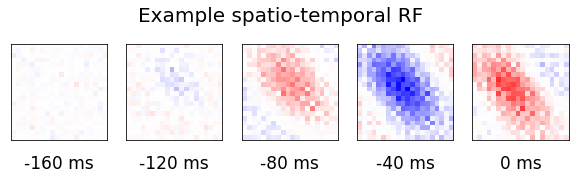

In [192]:
fig, axs = plt.subplots(1, len(spatiotemporal_rf), figsize=(10, 10))
st = fig.suptitle('Example spatio-temporal RF', fontsize=20)
for i in range(len(spatiotemporal_rf)):
    axs[i].imshow(spatiotemporal_rf[i], cmap='bwr', vmin=-v, vmax=v)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_xlabel('{0} ms'.format(-160+i*40), labelpad=15, fontsize=17)
st.set_y(0.62)

## 1.2. Viewing proportion of power of receptive fields

A useful measure in the analysis of spatio-temporal RFs is to view the population proportion of power over time, which is defined as the mean of the squared values of every spatial RF (averaged over all units). This measure informs us how much every preceding stimulus in time affects the response of all units. Typically the curve obtained is assymetric with more power being placed closer in time (i.e. real neuron responses are more actively driven by stimulus closer in time than further in time, however there is some dependence into the past).

In [213]:
power_profile = phys.get_temporal_power_profile(estimated_model_rfs).numpy()
labels = [-160, -120, -80, -40, 0]
power_profile_df = pd.DataFrame({'power': power_profile, 'time': labels})

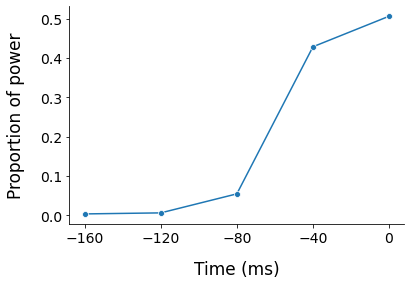

In [215]:
g = sns.lineplot(data=power_profile_df, x='time', y='power', marker='o')
g.set(xticks=labels)
g.set_xlabel('Time (ms)', labelpad=15, fontsize=17)
g.set_ylabel('Proportion of power', labelpad=15, fontsize=17)
g.tick_params(labelsize=14)
sns.despine()

# 2. Inspecting gabor fits

We can gain a deeper understanding of RF characteristics through a quantitative inspection (as opposed to a qualitatively viewing RFs). A common method enabling such quantitative analysis is by fitting gabor functions to RFs, where the parameters of these fits give us a more objective mean of analysing and comparing RFs.

Brainbox has gabor fitting functionallty which is outlined by the function below. Running this function can take a rather long time (albeit that it is optimised to run on mutiple CPU cores), hence it is advised to write a script and run this as a background process using the screen command. Note: The fitted parameters are included in this tutorial and hence you do not need to run the fitting function below to be able to render the remaining cells.

In [ ]:
# model_rfs: n_neurons x rf_len x width x height
phys.fit_gabors('misc', 'model_gabor.csv', model_rfs)

## 2.1. Viewing sample gabor fits

After the fitting is completed we can load our fitted parameters via the function below. We can specify various fitting parameters to ensure we are only loading the best gabor fits (see the documentation). In the figure below we plot the model RFs (top row) vs the corresponding fitted gabors (bottom row) and see that we get a good fit!

In [ ]:
validated_params_df, gabors, spatial_rfs, spatiotemporal_rfs = phys.get_gabors('misc', 'model_gabor.csv', estimated_model_rfs, min_cc=0.7, min_env=0.5, separability=None, inseperable_thresh=0.5)

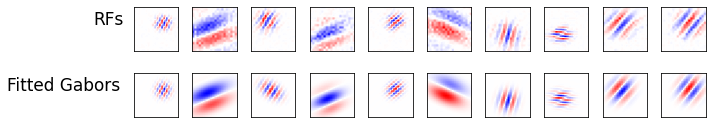

In [16]:
n = 10
fig, axs = plt.subplots(2, n, figsize=(10, 2))

for i in range(n):
    rf_v = spatial_rfs[i].abs().max()
    gabor_v = gabors[i].abs().max()
    axs[0, i].imshow(spatial_rfs[i], vmin=-rf_v, vmax=rf_v, cmap='bwr')
    axs[1, i].imshow(gabors[i], vmin=-gabor_v, vmax=gabor_v, cmap='bwr')
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
axs[0, 0].set_ylabel('Model RFs', rotation=0, labelpad=25, fontsize=17)
axs[1, 0].set_ylabel('Fitted Gabors', rotation=0, labelpad=70, fontsize=17)
    
fig.tight_layout()

# 2.2. Viewing space-time separable and inseparable RFs

Having fitted gabor functions to the model RFs allows us to compute so called space-time RFs, allowing for a better view of the temporal charactersistics of the spatio-temporal RFs. These space-time RFs have a fixed shape as we progress over the x-axis if the spatio-temporal RF are space-time separable (portrayed by rows $I-III$) or a shifting shape if the spatio-temporal RF are space-time inseparable (portrayed by rows $IV-VI$).

In [21]:
def load_rfs(root, name, model_rfs, separability):
    validated_params_df, gabors, spatial_rfs, spatiotemporal_rfs = phys.get_gabors(root, name, estimated_model_rfs, min_cc=0.7, min_env=0.5, separability=separability, inseperable_thresh=0.5)
    seperable_2d_rfs = phys.get_2D_spatiotemporal_rfs(validated_params_df, spatiotemporal_rfs)
    
    return seperable_2d_rfs, spatiotemporal_rfs
    

In [23]:
seperable_2d_rfs, seperable_rfs = load_rfs('misc', 'model_gabor.csv', estimated_model_rfs, 'separable')
inseperable_2d_rfs, inseperable_rfs = load_rfs('misc', 'model_gabor.csv', estimated_model_rfs, 'inseparable')

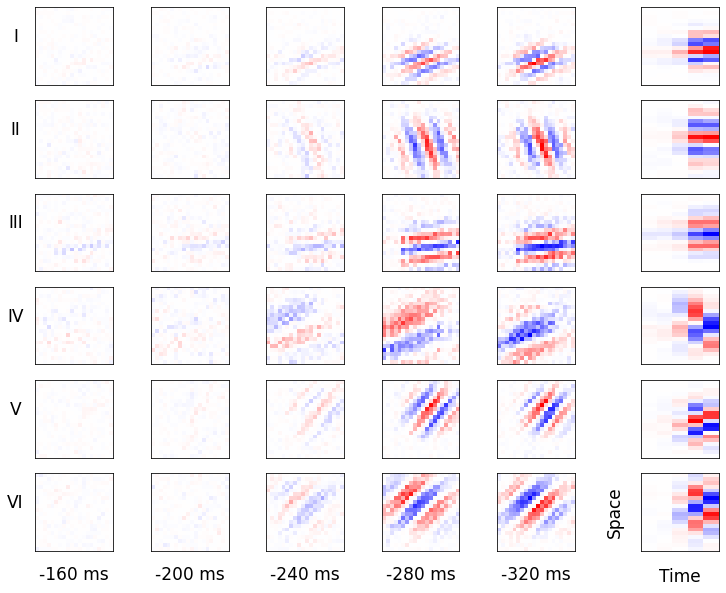

In [71]:
fig, axs = plt.subplots(6, 5, figsize=(10, 10))

def plot(i, rf, rf2d, label=''):
    axs[i, 0].set_ylabel(label, rotation=0, labelpad=20, fontsize=17)
    v = rf.abs().max()
    
    for j in range(5):
        img = axs[i, j].imshow(rf[j]/v, vmin=-1, vmax=1, cmap='bwr')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
    
    box = axs[i, 4].get_position()
    w = box.x1 - box.x0
    ax = fig.add_axes([box.x0+0.2, box.y0, w, w])
    ax.set_xticks([])
    ax.set_yticks([])
        
    if i == 5:
        ax.set_ylabel('Space', labelpad=17, fontsize=17)
        ax.set_xlabel('Time', labelpad=17, fontsize=17)
        
    v = rf2d.abs().max()
    ax.imshow(rf2d/v, interpolation='nearest', extent=[0,100,0,1], aspect=100, vmin=-1, vmax=1, cmap='bwr')

plot(0, seperable_rfs[3], seperable_2d_rfs[3], label='I')     
plot(1, seperable_rfs[13], seperable_2d_rfs[13], label='II')  
plot(2, seperable_rfs[17], seperable_2d_rfs[17], label='III')  
plot(3, inseperable_rfs[2], inseperable_2d_rfs[2], label='IV')  
plot(4, inseperable_rfs[6], inseperable_2d_rfs[6], label='V')  
plot(5, inseperable_rfs[12], inseperable_2d_rfs[12], label='VI')  

for i in range(5):
    axs[5, i].set_xlabel('{0} ms'.format(-160-i*40), labelpad=15, fontsize=17)

## 2.3. Viewing RF shape distribution

Furthermore, having fitted gabors allows us to visualise the distrubtion over the RF shapes through the so called $n_x-n_y$ plot. $n_x$ and $n_y$ measure RF span parallel and orthogonal to orientation tuning proportional to the spatial oscillation period. A large $n_y$ corresponds to a RF with long bars and a large $n_x$ corresponds to a RF with many bars.

In [72]:
nxs, nys = phys.get_rf_shape_distribution('misc', 'model_gabor.csv', estimated_model_rfs, min_cc=0.7, min_env=0.5, separability='separable', inseperable_thresh=0.5)

In [73]:
rf_shapes_df = pd.DataFrame({'nx': nxs, 'ny': nys})

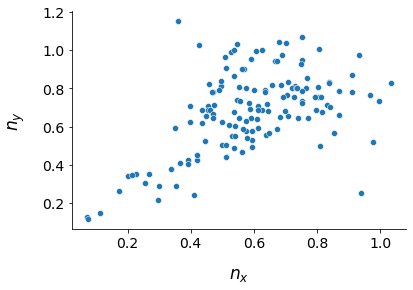

In [76]:
g = sns.scatterplot(data=rf_shapes_df, x='nx', y='ny', marker='o')
g.set_xlabel('$n_x$', labelpad=15, fontsize=17)
g.set_ylabel('$n_y$', labelpad=15, fontsize=17)
g.tick_params(labelsize=14)
sns.despine()